# 🤟 영상 수어 인식 모델 (CNN + GRU)

## 개요
- **입력**: JSON 키포인트 파일들 (프레임별)
- **모델**: CNN + GRU 하이브리드
- **출력**: 수어 단어 분류


## 핵심 기법
1. **CNN**: 공간적 특징 추출 (키포인트 간 관계)
2. **GRU**: 시간적 연속성 처리 (양방향)
3. **ELU 활성화**: 그래디언트 소실 방지
4. **Early Stopping**: 과적합 방지
5. **왼손잡이 증강**: 수평 반전
6. **홀드아웃 검증**: Train 80%, Val 10%, Test 10%

In [1]:
# =============================================================================
# Cell 1: 라이브러리 및 설정
# =============================================================================

import os
import re
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# sklearn, seaborn 설치 확인 및 임포트
try:
    from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
except ImportError:
    print("sklearn 설치 중...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

try:
    import seaborn as sns
except ImportError:
    print("seaborn 설치 중...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'seaborn'])
    import seaborn as sns

# 난수 생성기 설정
rng = np.random.default_rng(42)

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print("디바이스: {}".format(device))

# ╔═══════════════════════════════════════════════════════════════╗
# ║  ★★★ 각자 하실 때 여기만 수정 ★★★                                    ║
# ╚═══════════════════════════════════════════════════════════════╝
DATA_DIR = r"C:/j/dataset/자체제작_단어_keypoints"
MODEL_DIR = r"C:/j/models"
# ═══════════════════════════════════════════════════════════════════

os.makedirs(MODEL_DIR, exist_ok=True)

# 하이퍼파라미터
SEQUENCE_LENGTH = 30   # 프레임 수
BATCH_SIZE = 32        # 배치 크기
HIDDEN_DIM = 128       # 은닉층 차원
NUM_EPOCHS = 100       # 최대 에포크
LEARNING_RATE = 0.001  # 학습률
PATIENCE = 15          # Early Stopping patience
NUM_AUGMENT = 5        # 증강 배수

print("데이터 경로: {}".format(DATA_DIR))
print("모델 저장 경로: {}".format(MODEL_DIR))
print("시퀀스 길이: {} frames".format(SEQUENCE_LENGTH))

디바이스: cpu
데이터 경로: C:/j/dataset/자체제작_단어_keypoints
모델 저장 경로: C:/j/models
시퀀스 길이: 30 frames


In [5]:
# =============================================================================
# Cell 2: 데이터 로드 함수
# =============================================================================

def load_keypoints_from_json(json_path):
    """
    JSON 파일에서 키포인트 추출 (411차원)
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # 'people' 키가 없거나 비어있으면 0 반환
        if 'people' not in data or len(data['people']) == 0:
            return np.zeros(411, dtype=np.float32)
        
        person = data['people'][0]
        
    except (json.JSONDecodeError, UnicodeDecodeError, KeyError):
        return np.zeros(411, dtype=np.float32)
    
    # 각 부위 추출
    pose_raw = person.get('pose_keypoints_2d', [])
    face_raw = person.get('face_keypoints_2d', [])
    hand_left_raw = person.get('hand_left_keypoints_2d', [])
    hand_right_raw = person.get('hand_right_keypoints_2d', [])
    
    # numpy 배열로 변환 및 길이 조정
    pose = np.zeros(75, dtype=np.float32)
    face = np.zeros(210, dtype=np.float32)
    hand_left = np.zeros(63, dtype=np.float32)
    hand_right = np.zeros(63, dtype=np.float32)
    
    if pose_raw:
        pose[:min(len(pose_raw), 75)] = np.array(pose_raw[:75], dtype=np.float32)
    if face_raw:
        face[:min(len(face_raw), 210)] = np.array(face_raw[:210], dtype=np.float32)
    if hand_left_raw:
        hand_left[:min(len(hand_left_raw), 63)] = np.array(hand_left_raw[:63], dtype=np.float32)
    if hand_right_raw:
        hand_right[:min(len(hand_right_raw), 63)] = np.array(hand_right_raw[:63], dtype=np.float32)
    
    return np.concatenate([pose, face, hand_left, hand_right])


def load_sequence_from_folder(folder_path, sequence_length):
    """
    폴더 내 JSON 파일들을 시퀀스로 로드
    """
    json_files = sorted(glob.glob(os.path.join(folder_path, '*.json')))
    
    if len(json_files) == 0:
        return None
    
    all_keypoints = []
    for json_file in json_files:
        keypoints = load_keypoints_from_json(json_file)
        all_keypoints.append(keypoints)
    
    all_keypoints = np.array(all_keypoints, dtype=np.float32)
    
    # 시퀀스 길이 조정
    if len(all_keypoints) >= sequence_length:
        start = (len(all_keypoints) - sequence_length) // 2
        return all_keypoints[start:start + sequence_length]
    else:
        pad_len = sequence_length - len(all_keypoints)
        pad_before = pad_len // 2
        pad_after = pad_len - pad_before
        return np.concatenate([
            np.tile(all_keypoints[0:1], (pad_before, 1)),
            all_keypoints,
            np.tile(all_keypoints[-1:], (pad_after, 1))
        ])


def extract_label(folder_name):
    """폴더명에서 라벨 추출: 'ㄱㄹ_3(2)' -> 'ㄱㄹ_3'"""
    return re.sub(r'\(\d+\)$', '', folder_name)


def load_all_data(data_dir, sequence_length):
    """
    전체 데이터셋 로드
    """
    folders = sorted([d for d in os.listdir(data_dir) 
                     if os.path.isdir(os.path.join(data_dir, d))])
    
    # 클래스 매핑
    unique_labels = sorted(set(extract_label(f) for f in folders))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    print("발견된 폴더: {}개".format(len(folders)))
    print("고유 클래스: {}개".format(len(unique_labels)))
    print("클래스 목록: {}\n".format(unique_labels))
    
    # 데이터 로드
    sequences = []
    labels = []
    for folder in folders:
        seq = load_sequence_from_folder(os.path.join(data_dir, folder), sequence_length)
        if seq is not None:
            sequences.append(seq)
            labels.append(label_to_idx[extract_label(folder)])
    
    data_x = np.array(sequences, dtype=np.float32)
    data_y = np.array(labels, dtype=np.int64)
    
    print("데이터 로드 완료: X={}, Y={}".format(data_x.shape, data_y.shape))
    
    # 클래스별 샘플 수
    print("\n클래스별 샘플 수:")
    for label, idx in label_to_idx.items():
        count = int((data_y == idx).sum())
        print("   {}: {}개".format(label, count))
    
    return data_x, data_y, label_to_idx, idx_to_label


# 데이터 로드
print("=" * 60)
print("데이터 로드 중...")
print("=" * 60)

X_raw, Y_raw, label_to_idx, idx_to_label = load_all_data(DATA_DIR, SEQUENCE_LENGTH)
num_classes = len(label_to_idx)

데이터 로드 중...
발견된 폴더: 195개
고유 클래스: 65개
클래스 목록: ['ㅘ_1', 'ㅘ_2', 'ㅘ_3', 'ㅘ_4', 'ㅘ_5', 'ㅙ_1', 'ㅙ_2', 'ㅙ_3', 'ㅙ_4', 'ㅙ_5', 'ㅝ_1', 'ㅝ_2', 'ㅝ_3', 'ㅝ_4', 'ㅝ_5', 'ㅞ_1', 'ㅞ_2', 'ㅞ_3', 'ㅞ_4', 'ㅞ_5', '많다_1', '많다_2', '많다_3', '많다_4', '많다_5', '모르다_1', '모르다_2', '모르다_3', '모르다_4', '모르다_5', '반갑습니다_1', '반갑습니다_2', '반갑습니다_3', '반갑습니다_4', '반갑습니다_5', '싫다_1', '싫다_2', '싫다_3', '싫다_4', '싫다_5', '안녕하세요_1', '안녕하세요_2', '안녕하세요_3', '안녕하세요_4', '안녕하세요_5', '입니다_1', '입니다_2', '입니다_3', '입니다_4', '입니다_5', '저는_1', '저는_2', '저는_3', '저는_4', '저는_5', '적다_1', '적다_2', '적다_3', '적다_4', '적다_5', '좋다_1', '좋다_2', '좋다_3', '좋다_4', '좋다_5']

데이터 로드 완료: X=(195, 30, 411), Y=(195,)

클래스별 샘플 수:
   ㅘ_1: 3개
   ㅘ_2: 3개
   ㅘ_3: 3개
   ㅘ_4: 3개
   ㅘ_5: 3개
   ㅙ_1: 3개
   ㅙ_2: 3개
   ㅙ_3: 3개
   ㅙ_4: 3개
   ㅙ_5: 3개
   ㅝ_1: 3개
   ㅝ_2: 3개
   ㅝ_3: 3개
   ㅝ_4: 3개
   ㅝ_5: 3개
   ㅞ_1: 3개
   ㅞ_2: 3개
   ㅞ_3: 3개
   ㅞ_4: 3개
   ㅞ_5: 3개
   많다_1: 3개
   많다_2: 3개
   많다_3: 3개
   많다_4: 3개
   많다_5: 3개
   모르다_1: 3개
   모르다_2: 3개
   모르다_3: 3개
   모르다_4: 3개
   모르다_5: 3개
   반갑습니다_1: 3개
   

In [6]:
# =============================================================================
# Cell 3: 데이터 증강
# =============================================================================

def augment_sequence(seq, rng, flip=False):
    """
    데이터 증강
    - 노이즈 추가
    - 시간 워핑
    - 수평 반전 (왼손잡이 보정)
    """
    seq = seq.copy()
    num_frames = seq.shape[0]
    
    # 1. 수평 반전 (왼손 ↔ 오른손)
    if flip:
        # x좌표 반전
        for t in range(num_frames):
            for i in range(0, 411, 3):
                seq[t, i] = 1.0 - seq[t, i]
        # 손 교체
        for t in range(num_frames):
            left = seq[t, 285:348].copy()   # hand_left
            right = seq[t, 348:411].copy()  # hand_right
            seq[t, 285:348] = right
            seq[t, 348:411] = left
    
    # 2. 노이즈
    noise = rng.normal(0, 0.01, seq.shape)
    seq = seq + noise
    
    # 3. 시간 워핑
    if rng.random() > 0.5:
        warp = rng.uniform(0.9, 1.1)
        new_len = max(1, int(num_frames * warp))
        indices = np.linspace(0, num_frames - 1, new_len)
        
        warped_list = []
        for d in range(411):
            warped_list.append(np.interp(indices, np.arange(num_frames), seq[:, d]))
        warped = np.array(warped_list).T
        
        if len(warped) >= num_frames:
            start = (len(warped) - num_frames) // 2
            seq = warped[start:start + num_frames]
        else:
            pad = num_frames - len(warped)
            pad_before = pad // 2
            pad_after = pad - pad_before
            seq = np.concatenate([
                np.tile(warped[0:1], (pad_before, 1)), 
                warped, 
                np.tile(warped[-1:], (pad_after, 1))
            ])
    
    return seq.astype(np.float32)


def apply_augmentation(data_x, data_y, num_augment, flip_prob=0.3):
    """전체 데이터셋 증강"""
    augmented_x = []
    augmented_y = []
    local_rng = np.random.default_rng(42)
    
    for i in range(len(data_x)):
        augmented_x.append(data_x[i])  # 원본
        augmented_y.append(data_y[i])
        
        for _ in range(num_augment):
            do_flip = local_rng.random() < flip_prob
            augmented_seq = augment_sequence(data_x[i], local_rng, flip=do_flip)
            augmented_x.append(augmented_seq)
            augmented_y.append(data_y[i])
    
    return np.array(augmented_x, dtype=np.float32), np.array(augmented_y, dtype=np.int64)


# 증강 적용
print("\n" + "=" * 60)
print("데이터 증강 중...")
print("=" * 60)
X_aug, Y_aug = apply_augmentation(X_raw, Y_raw, NUM_AUGMENT)
print("원본: {}개 -> 증강 후: {}개 ({}x)".format(len(X_raw), len(X_aug), len(X_aug) // len(X_raw)))


데이터 증강 중...
원본: 195개 -> 증강 후: 1170개 (6x)


In [7]:
# =============================================================================
# Cell 4: 정규화 및 데이터 분할 (80/10/10)
# =============================================================================

# 정규화
X_mean = X_aug.mean(axis=(0, 1), keepdims=True)
X_std = X_aug.std(axis=(0, 1), keepdims=True) + 1e-8
X_norm = (X_aug - X_mean) / X_std

norm_params = {'mean': X_mean, 'std': X_std}

print("정규화 완료")
print("   Before: mean={:.4f}, std={:.4f}".format(X_aug.mean(), X_aug.std()))
print("   After:  mean={:.4f}, std={:.4f}".format(X_norm.mean(), X_norm.std()))

# 텐서 변환 및 분할
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_aug, dtype=torch.long)

total = len(X_tensor)
train_size = int(0.8 * total)
val_size = int(0.1 * total)

indices = torch.randperm(total)
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, Y_train = X_tensor[train_idx], Y_tensor[train_idx]
X_val, Y_val = X_tensor[val_idx], Y_tensor[val_idx]
X_test, Y_test = X_tensor[test_idx], Y_tensor[test_idx]

print("\n홀드아웃 분할 완료")
print("   Train: {}개 (80%)".format(len(X_train)))
print("   Val:   {}개 (10%)".format(len(X_val)))
print("   Test:  {}개 (10%)".format(len(X_test)))


# DataLoader
class SignDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


train_loader = DataLoader(
    SignDataset(X_train, Y_train), 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    SignDataset(X_val, Y_val), 
    batch_size=BATCH_SIZE,
    num_workers=0
)
test_loader = DataLoader(
    SignDataset(X_test, Y_test), 
    batch_size=BATCH_SIZE,
    num_workers=0
)

print("\nDataLoader 생성 완료 (batch_size={})".format(BATCH_SIZE))

정규화 완료
   Before: mean=0.3345, std=0.3137
   After:  mean=-0.0000, std=1.0000

홀드아웃 분할 완료
   Train: 936개 (80%)
   Val:   117개 (10%)
   Test:  117개 (10%)

DataLoader 생성 완료 (batch_size=32)


In [8]:
# =============================================================================
# Cell 5: CNN + GRU 모델
# =============================================================================

class CnnGruModel(nn.Module):
    """
    CNN + GRU 하이브리드 모델
    
    구조:
    1. Spatial CNN  → 키포인트 간 공간적 관계
    2. Temporal CNN → 시간 축 특징
    3. Bidirectional GRU → 시간적 연속성
    4. Attention → 중요 프레임 집중
    5. Classifier → 최종 분류
    
    활성화 함수: ELU (그래디언트 소실 방지)
    """
    
    def __init__(self, input_dim=411, hidden_dim=128, num_layers=2, 
                 num_classes=10, dropout=0.3):
        super(CnnGruModel, self).__init__()
        
        # Spatial CNN
        self.spatial = nn.Sequential(
            nn.Conv1d(input_dim, 256, 1),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Conv1d(256, hidden_dim, 1),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
        )
        
        # Temporal CNN
        self.temporal = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
        )
        
        # Bidirectional GRU
        gru_dropout = dropout if num_layers > 1 else 0
        self.gru = nn.GRU(
            hidden_dim, hidden_dim, num_layers,
            batch_first=True, dropout=gru_dropout,
            bidirectional=True
        )
        
        # Attention
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        # x: (batch, seq_len, 411)
        x = x.permute(0, 2, 1)           # (batch, 411, seq_len)
        x = self.spatial(x)              # (batch, hidden, seq_len)
        x = self.temporal(x)             # (batch, hidden, seq_len)
        x = x.permute(0, 2, 1)           # (batch, seq_len, hidden)
        gru_output, _ = self.gru(x)      # (batch, seq_len, hidden*2)
        attn = self.attention(gru_output)  # (batch, seq_len, 1)
        context = torch.sum(gru_output * attn, dim=1)  # (batch, hidden*2)
        output = self.classifier(context)  # (batch, num_classes)
        return output


# 모델 생성
model = CnnGruModel(
    input_dim=411,
    hidden_dim=HIDDEN_DIM,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.3
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("CNN + GRU 모델")
print("=" * 60)
print("입력: (batch, {}, 411)".format(SEQUENCE_LENGTH))
print("출력: {} classes".format(num_classes))
print("파라미터: {:,}개".format(total_params))
print("활성화 함수: ELU")

CNN + GRU 모델
입력: (batch, 30, 411)
출력: 65 classes
파라미터: 807,106개
활성화 함수: ELU


In [9]:
# =============================================================================
# Cell 6: Early Stopping
# =============================================================================

class EarlyStopping:
    """검증 손실이 patience 동안 개선 안되면 중단"""
    
    def __init__(self, patience=10):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
    
    def check(self, val_loss, model):
        if val_loss < self.best_loss - 0.0001:
            self.best_loss = val_loss
            self.counter = 0
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            return False
        
        self.counter += 1
        if self.counter >= self.patience:
            if self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            print("\nEarly Stopping! (best val_loss: {:.4f})".format(self.best_loss))
            return True
        return False

print("Early Stopping 정의 완료")

Early Stopping 정의 완료


In [10]:
# =============================================================================
# Cell 7: 학습
# =============================================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=PATIENCE)

history = {
    'train_loss': [], 
    'train_acc': [], 
    'val_loss': [], 
    'val_acc': []
}
best_val_acc = 0.0

print("=" * 60)
print("학습 시작")
print("Epochs: {}, LR: {}, Patience: {}".format(NUM_EPOCHS, LEARNING_RATE, PATIENCE))
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
        predictions = output.argmax(1)
        train_correct += (predictions == batch_y).sum().item()
        train_total += batch_y.size(0)
    
    train_loss = train_loss / train_total
    train_acc = 100.0 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            predictions = output.argmax(1)
            val_correct += (predictions == batch_y).sum().item()
            val_total += batch_y.size(0)
    
    val_loss = val_loss / val_total
    val_acc = 100.0 * val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    # 출력
    if (epoch + 1) % 5 == 0 or val_acc > best_val_acc:
        marker = "BEST" if val_acc > best_val_acc else ""
        print("Epoch {:3d}/{} | Loss: {:.4f}/{:.4f} | Acc: {:.1f}%/{:.1f}% {}".format(
            epoch + 1, NUM_EPOCHS, train_loss, val_loss, train_acc, val_acc, marker))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    if early_stopping.check(val_loss, model):
        break

print("=" * 60)
print("학습 완료! 최고 검증 정확도: {:.2f}%".format(best_val_acc))
print("=" * 60)

학습 시작
Epochs: 100, LR: 0.001, Patience: 15
Epoch   1/100 | Loss: 3.7332/3.1589 | Acc: 6.9%/11.1% BEST
Epoch   3/100 | Loss: 2.6159/2.2791 | Acc: 13.4%/17.9% BEST
Epoch   5/100 | Loss: 2.3555/2.0504 | Acc: 18.3%/12.8% 
Epoch   6/100 | Loss: 2.1733/1.8781 | Acc: 18.3%/25.6% BEST
Epoch  10/100 | Loss: 1.9403/1.8263 | Acc: 23.2%/22.2% 
Epoch  11/100 | Loss: 1.8653/1.7070 | Acc: 25.4%/26.5% BEST
Epoch  12/100 | Loss: 1.8011/1.6377 | Acc: 27.7%/29.9% BEST
Epoch  14/100 | Loss: 1.7081/1.5715 | Acc: 31.0%/30.8% BEST
Epoch  15/100 | Loss: 1.6256/1.5089 | Acc: 34.9%/29.1% 
Epoch  16/100 | Loss: 1.6445/1.5093 | Acc: 32.6%/35.9% BEST
Epoch  19/100 | Loss: 1.5843/1.4021 | Acc: 34.7%/41.9% BEST
Epoch  20/100 | Loss: 1.4747/1.4601 | Acc: 40.3%/35.9% 
Epoch  25/100 | Loss: 1.3464/1.3769 | Acc: 44.8%/43.6% BEST
Epoch  26/100 | Loss: 1.2532/1.1430 | Acc: 50.0%/53.8% BEST
Epoch  29/100 | Loss: 1.1772/1.0707 | Acc: 51.0%/55.6% BEST
Epoch  30/100 | Loss: 1.1507/1.2163 | Acc: 55.1%/47.0% 
Epoch  32/100 | Lo

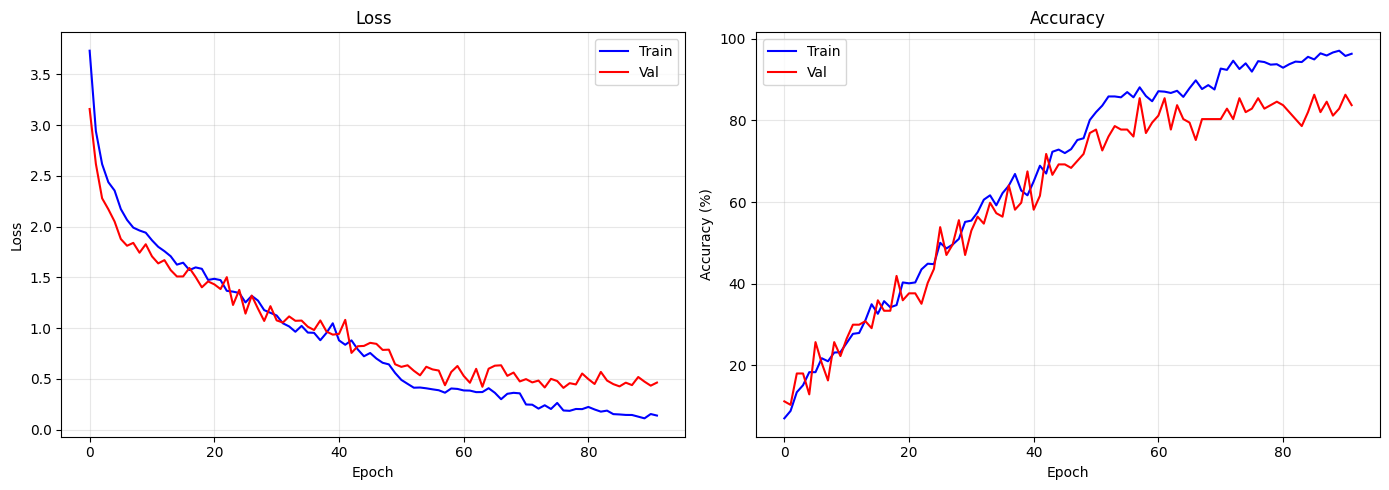

저장: C:/j/models\training_history.png


In [11]:
# =============================================================================
# Cell 8: 학습 곡선 시각화
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], 'b-', label='Train')
axes[0].plot(history['val_loss'], 'r-', label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], 'b-', label='Train')
axes[1].plot(history['val_acc'], 'r-', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
history_path = os.path.join(MODEL_DIR, 'training_history.png')
plt.savefig(history_path, dpi=150)
plt.show()
print("저장: {}".format(history_path))

테스트 결과
   정확도 (Accuracy):   87.18%
   정밀도 (Precision):  86.42%
   재현율 (Recall):     87.18%
   F1-Score:            85.46%

클래스별 성능:
              precision    recall  f1-score   support

         ㅘ_1       1.00      1.00      1.00         1
         ㅘ_2       0.50      1.00      0.67         1
         ㅘ_3       0.00      0.00      0.00         1
         ㅘ_4       1.00      1.00      1.00         3
         ㅘ_5       0.67      1.00      0.80         2
         ㅙ_1       1.00      1.00      1.00         1
         ㅙ_2       1.00      1.00      1.00         2
         ㅙ_3       1.00      1.00      1.00         3
         ㅙ_4       1.00      1.00      1.00         3
         ㅙ_5       1.00      1.00      1.00         3
         ㅝ_1       1.00      1.00      1.00         2
         ㅝ_2       1.00      1.00      1.00         2
         ㅝ_3       1.00      1.00      1.00         2
         ㅝ_4       1.00      0.67      0.80         3
         ㅝ_5       1.00      1.00      1.00         3
   

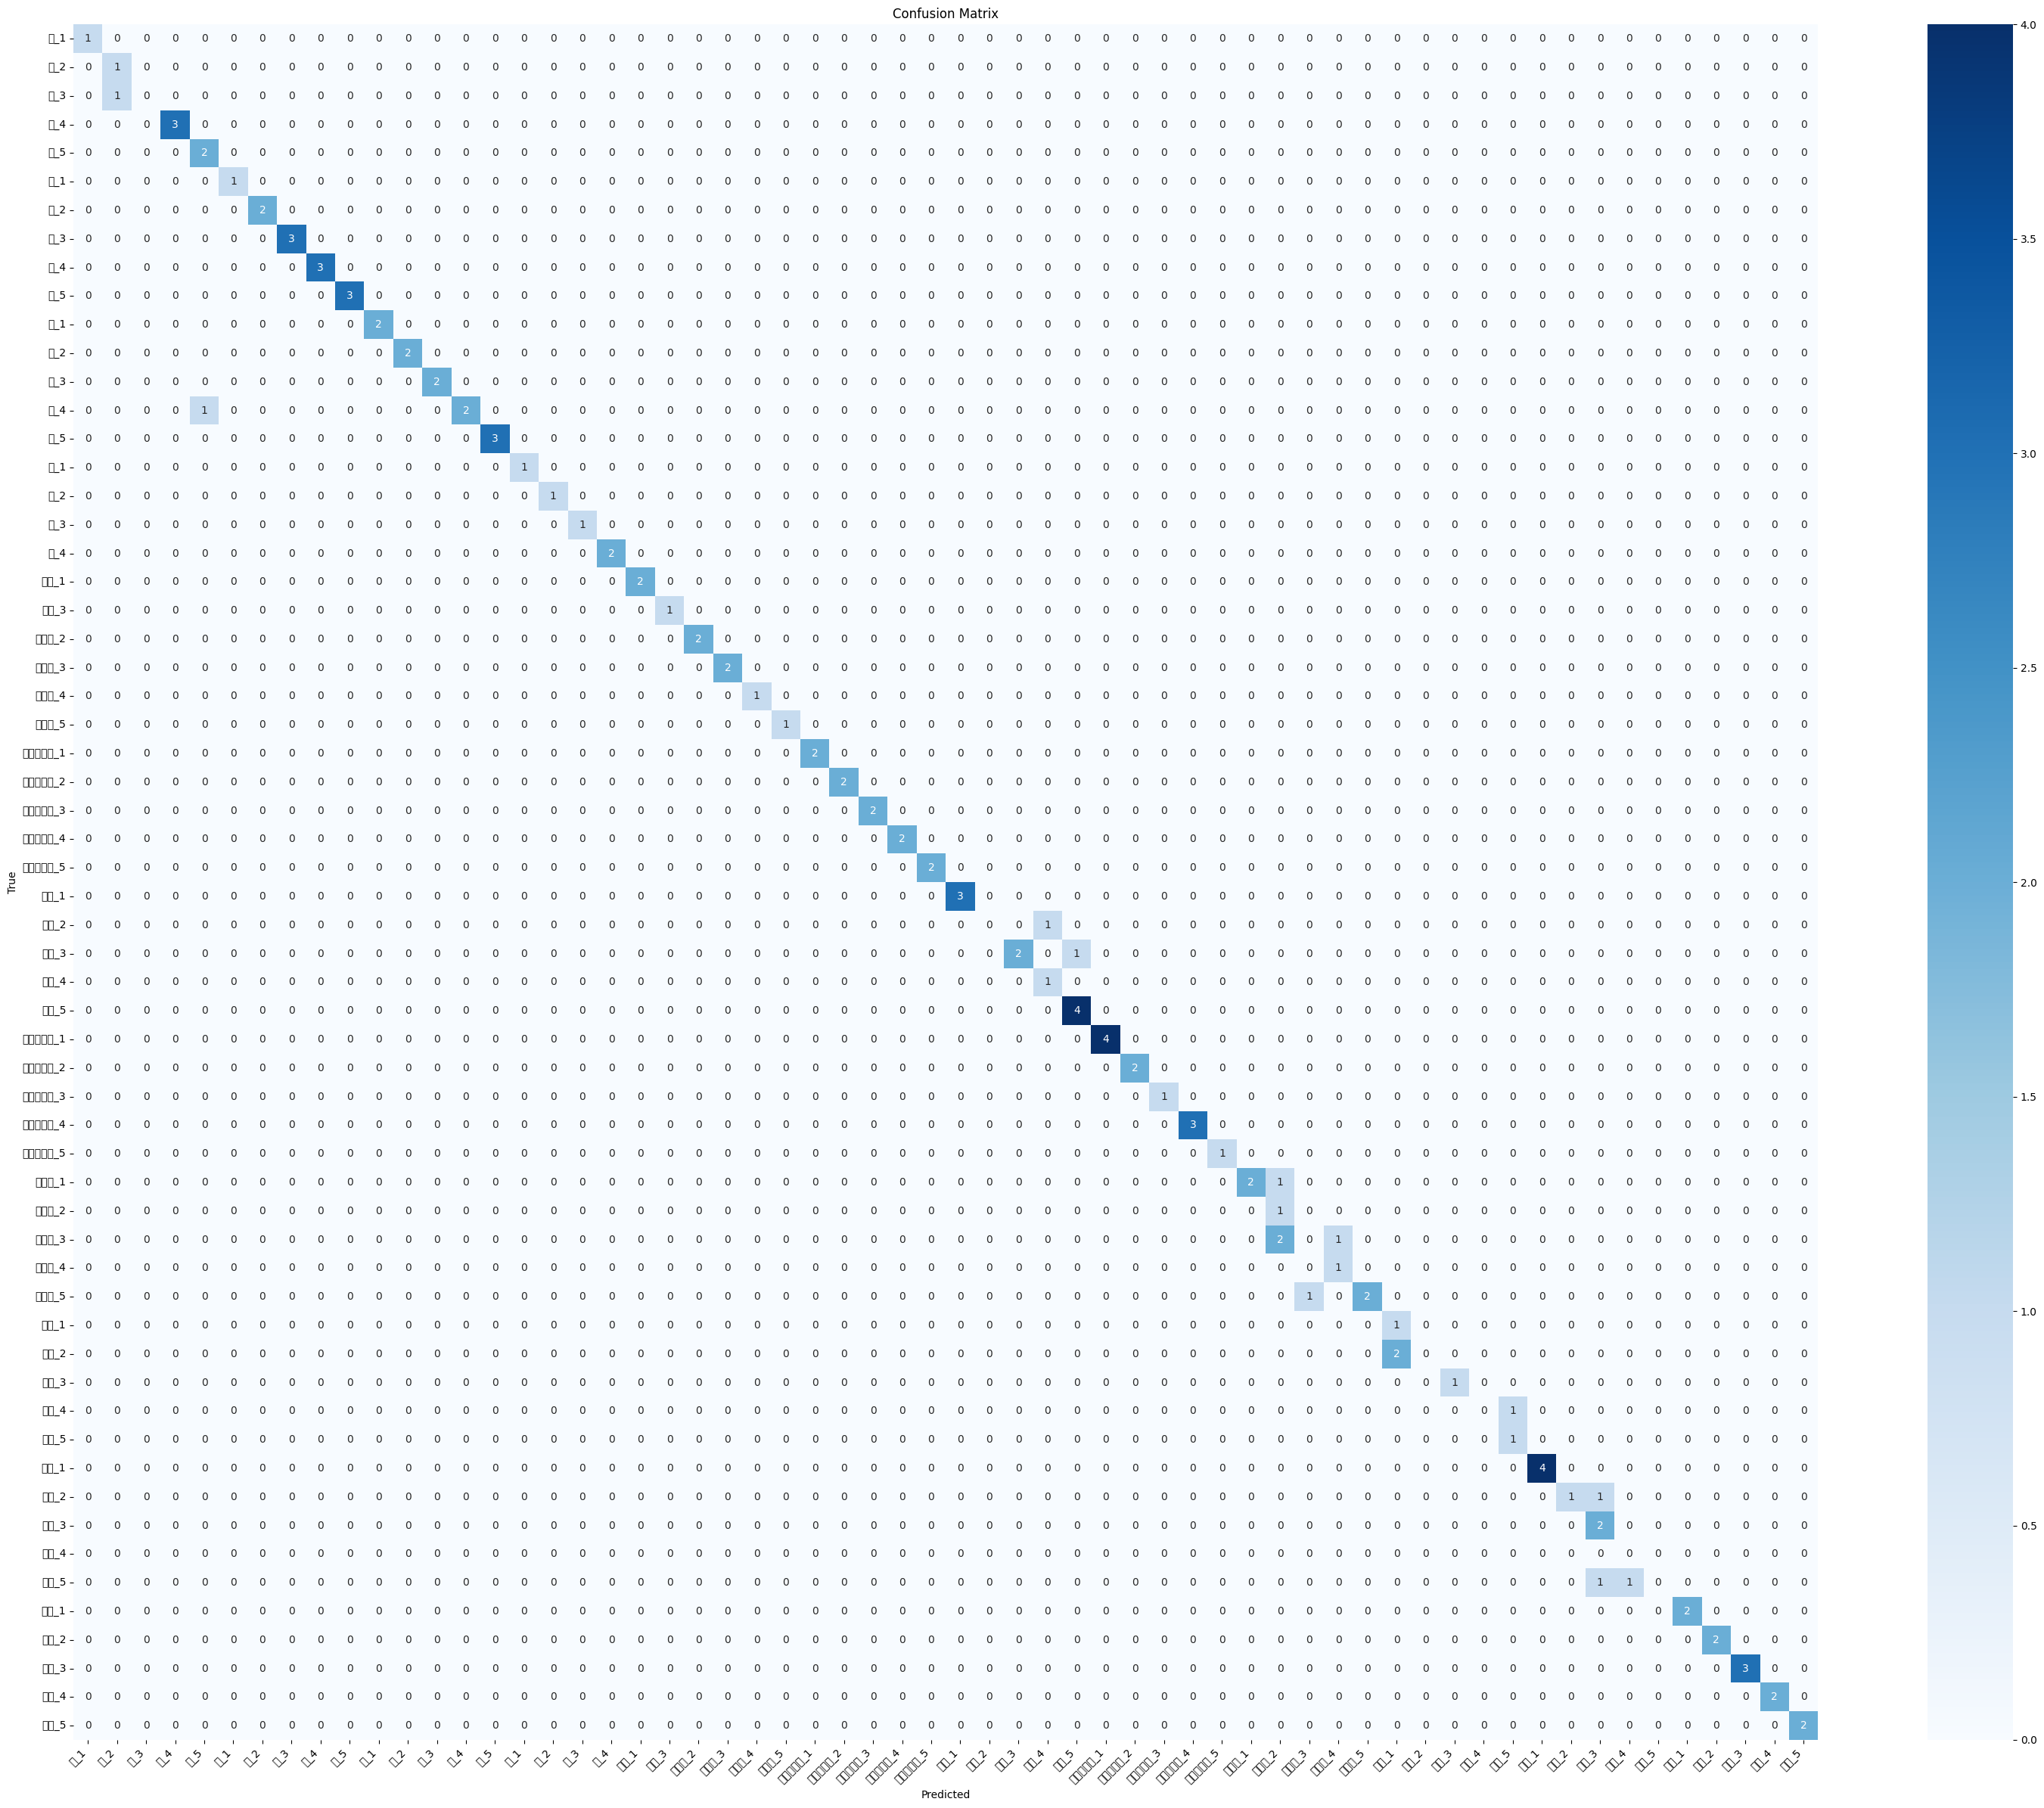

저장: C:/j/models\confusion_matrix.png


In [13]:
# =============================================================================
# Cell 9: 테스트 평가
# =============================================================================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        preds = model(batch_x).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 성능 지표
accuracy = 100.0 * (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0) * 100
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) * 100

print("=" * 60)
print("테스트 결과")
print("=" * 60)
print("   정확도 (Accuracy):   {:.2f}%".format(accuracy))
print("   정밀도 (Precision):  {:.2f}%".format(precision))
print("   재현율 (Recall):     {:.2f}%".format(recall))
print("   F1-Score:            {:.2f}%".format(f1))
print("=" * 60)

# 테스트셋에 실제로 있는 클래스만 사용
unique_labels_in_test = sorted(set(all_labels) | set(all_preds))
target_names = [idx_to_label[i] for i in unique_labels_in_test]

# 클래스별 성능
print("\n클래스별 성능:")
print(classification_report(all_labels, all_preds, labels=unique_labels_in_test, target_names=target_names, zero_division=0))

# 혼동 행렬
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels_in_test)
fig_width = max(10, len(unique_labels_in_test) * 0.5)
fig_height = max(8, len(unique_labels_in_test) * 0.4)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
cm_path = os.path.join(MODEL_DIR, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150)
plt.show()
print("저장: {}".format(cm_path))

test_results = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1_score': f1
}

In [14]:
# =============================================================================
# Cell 10: 모델 저장
# =============================================================================

save_path = os.path.join(MODEL_DIR, 'sign_language_cnn_gru.pt')

save_data = {
    'model_state_dict': model.state_dict(),
    'norm_params': {
        'mean': norm_params['mean'].tolist(), 
        'std': norm_params['std'].tolist()
    },
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'num_classes': num_classes,
    'config': {
        'input_dim': 411,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': 2,
        'sequence_length': SEQUENCE_LENGTH
    },
    'history': history,
    'test_results': test_results
}

torch.save(save_data, save_path)

print("=" * 60)
print("모델 저장 완료: {}".format(save_path))
print("=" * 60)
print("   - 모델 가중치")
print("   - 정규화 파라미터")
print("   - 라벨 매핑 ({}개 클래스)".format(num_classes))
print("   - 학습 기록")
print("   - 테스트 결과")

모델 저장 완료: C:/j/models\sign_language_cnn_gru.pt
   - 모델 가중치
   - 정규화 파라미터
   - 라벨 매핑 (65개 클래스)
   - 학습 기록
   - 테스트 결과


In [17]:
# =============================================================================
# Cell 11: 추론 함수 (새 데이터 예측용)
# =============================================================================

def load_trained_model(path, device):
    """저장된 모델 로드"""
    checkpoint = torch.load(path, map_location=device)
    cfg = checkpoint['config']
    
    loaded_model = CnnGruModel(
        input_dim=cfg['input_dim'],
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers'],
        num_classes=checkpoint['num_classes'],
        dropout=0
    ).to(device)
    
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    loaded_norm = {
        'mean': np.array(checkpoint['norm_params']['mean']),
        'std': np.array(checkpoint['norm_params']['std'])
    }
    
    return loaded_model, checkpoint['idx_to_label'], loaded_norm, cfg['sequence_length']


def predict(folder_path, model, idx_to_label, norm, seq_len):
    """JSON 폴더에서 수어 예측"""
    seq = load_sequence_from_folder(folder_path, seq_len)
    if seq is None:
        return None, 0.0
    
    # 정규화 (차원 맞추기)
    mean = np.array(norm['mean']).squeeze()
    std = np.array(norm['std']).squeeze()
    seq = (seq - mean) / std
    
    # 텐서 변환
    input_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, 1)
        conf, idx = prob.max(1)
    
    return idx_to_label[idx.item()], conf.item()


print("추론 함수 정의 완료")
print("\n사용법:")
print("   model, idx_to_label, norm, seq_len = load_trained_model('모델경로.pt', device)")
print("   label, confidence = predict('JSON폴더경로', model, idx_to_label, norm, seq_len)")

추론 함수 정의 완료

사용법:
   model, idx_to_label, norm, seq_len = load_trained_model('모델경로.pt', device)
   label, confidence = predict('JSON폴더경로', model, idx_to_label, norm, seq_len)


In [18]:
# =============================================================================
# Cell 12: 예측 테스트
# =============================================================================

# 첫 번째 폴더로 테스트
folder_list = os.listdir(DATA_DIR)
test_folder = os.path.join(DATA_DIR, folder_list[0])
pred_label, confidence = predict(test_folder, model, idx_to_label, norm_params, SEQUENCE_LENGTH)

print("\n예측 테스트")
print("   폴더: {}".format(os.path.basename(test_folder)))
print("   예측: {}".format(pred_label))
print("   신뢰도: {:.1f}%".format(confidence * 100))


예측 테스트
   폴더: ㅘ_1
   예측: ㅘ_1
   신뢰도: 51.2%
